# Understanding Deepfakes with Keras

![DCGAN](DCGAN.png)

# Task 1: Importing Libraries and Helper Functions

Please note: If you haven't already, please install the required packages by executing the code cell below.

In [1]:
%matplotlib notebook
%matplotlib inline

import tensorflow as tf
import numpy as np
import os

from matplotlib import pyplot as plt
from tensorflow.keras.layers import Dense, Flatten, Conv2D, BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose, Reshape, LeakyReLU
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.datasets import mnist

from PIL import Image


print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.3.0


# Task 2: Importing and Plotting the Data

In [15]:
def filter_0(x, y):
    keep = (y == 0)
    x, y = x[keep], y[keep]
    return x,y

In [40]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))
print(" ")

x_train, y_train = filter_0(x_train, y_train)
x_test, y_test = filter_0(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))
print(" ")

x = np.concatenate([x_train,x_test], axis=0)
y = np.concatenate([y_train,y_test], axis=0)

print("Number of filtered training examples:", len(x))
print("Number of filtered test examples:", len(y))

Number of filtered training examples: 60000
Number of filtered test examples: 10000
 
Number of filtered training examples: 5923
Number of filtered test examples: 980
 
Number of filtered training examples: 6903
Number of filtered test examples: 6903


In [42]:
x = (x - 127.5) / 127.5 # Normalize the images to [-1, 1]
x[0]

array([[-1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        ],
       [-1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        ],
       [-1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.    

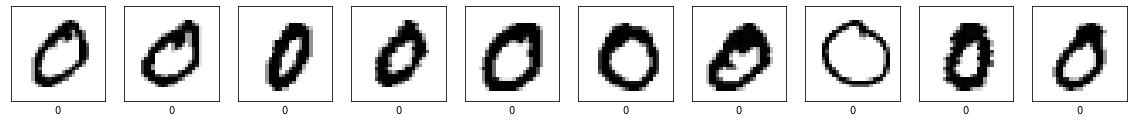

In [32]:
def plot(x, p, labels = False):
    plt.figure(figsize=(20,2))
    for i in range(10):
        plt.subplot(1,10,i+1)
        plt.imshow(x[i], cmap='binary')
        plt.xticks([])
        plt.yticks([])
        if labels:
            plt.xlabel(p[i])
    plt.show()
    return
plot(x,y, True )

# Task 3: Discriminator

![Artist and Critic](artist_critic.png)

In [23]:
discriminator = Sequential([

    Conv2D(64, 3, strides=2, input_shape=(28, 28, 1)),
    LeakyReLU(),
    BatchNormalization(),

    Conv2D(128, 5, strides=2),
    LeakyReLU(),
    BatchNormalization(),

    Conv2D(256, 5, strides=2),
    LeakyReLU(),
    BatchNormalization(),

    Flatten(),
    Dense(1, activation='sigmoid')
])
opt = tf.keras.optimizers.Adam(lr=2e-4, beta_1=0.5)

discriminator.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 13, 13, 64)        640       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 13, 13, 64)        0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 13, 13, 64)        256       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 5, 5, 128)         204928    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 5, 5, 128)         0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 5, 5, 128)         512       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 1, 1, 256)        

# Task 4: Generator

In [24]:
generator = Sequential([
    Dense(256, activation='relu', input_shape=(1,)),
    Reshape((1, 1, 256)),

    Conv2DTranspose(256, 5, activation='relu'),
    BatchNormalization(),

    Conv2DTranspose(128, 5, activation='relu'),
    BatchNormalization(),
    
    Conv2DTranspose(64, 5, strides=2, activation='relu'),
    BatchNormalization(),
    
    Conv2DTranspose(32, 5,  activation='relu'),
    BatchNormalization(),

    Conv2DTranspose(1, 4, activation='sigmoid')
    
])

generator.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 256)               512       
_________________________________________________________________
reshape_1 (Reshape)          (None, 1, 1, 256)         0         
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 5, 5, 256)         1638656   
_________________________________________________________________
batch_normalization_13 (Batc (None, 5, 5, 256)         1024      
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 9, 9, 128)         819328    
_________________________________________________________________
batch_normalization_14 (Batc (None, 9, 9, 128)         512       
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 21, 21, 64)       

In [25]:
noise = np.random.randn(1, 1)
gen_img = generator.predict(noise)[0]
gen_img = np.reshape(gen_img, (28,28))


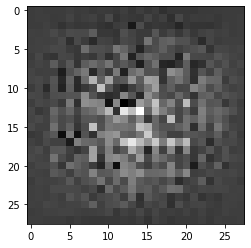

In [26]:
plt.figure()
plt.imshow(gen_img, cmap='gray')
plt.show()

# Task 5: Generative Adversarial Network (GAN)

In [27]:
input_layer = tf.keras.layers.Input(shape=(1,))
gen_out = generator(input_layer)
disc_out = discriminator(gen_out)

GAN = Model(
    input_layer,
    disc_out
)

discriminator.trainable = False
GAN.compile(loss='binary_crossentropy', optimizer = opt, metrics = ['accuracy'])
GAN.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
sequential_4 (Sequential)    (None, 28, 28, 1)         2717025   
_________________________________________________________________
sequential_3 (Sequential)    (None, 1)                 1027073   
Total params: 3,744,098
Trainable params: 2,716,065
Non-trainable params: 1,028,033
_________________________________________________________________


# Tasks 6 and 7: Training the GAN

In [28]:
epochs = 100
batch_size = 128
step_per_epoch = int(2 * x.shape[0]/batch_size)

print(f'step per epoch {step_per_epoch}')

step per epoch 107


DicAcc: 0.953125 ganLoss: 1.8677294254302979 


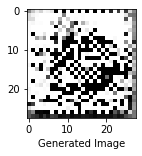

DicAcc: 0.5 ganLoss: 15.30079174041748 


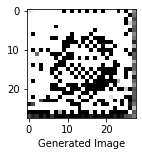

DicAcc: 0.5 ganLoss: 22.152740478515625 


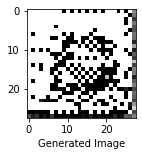

DicAcc: 0.5 ganLoss: 25.519763946533203 


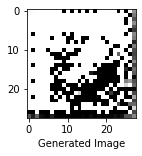

DicAcc: 0.5 ganLoss: 27.343944549560547 


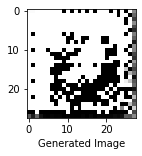

DicAcc: 0.5 ganLoss: 27.285690307617188 


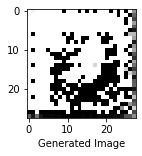

DicAcc: 0.6171875 ganLoss: 26.18985366821289 


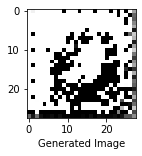

DicAcc: 1.0 ganLoss: 23.96858024597168 


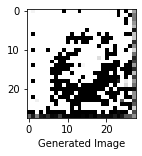

DicAcc: 1.0 ganLoss: 21.104854583740234 


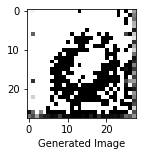

DicAcc: 1.0 ganLoss: 19.731061935424805 


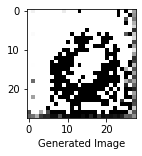

DicAcc: 1.0 ganLoss: 18.84486198425293 


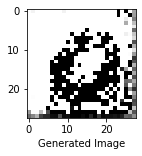

DicAcc: 1.0 ganLoss: 18.438720703125 


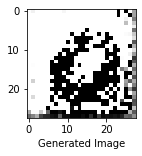

DicAcc: 1.0 ganLoss: 18.291973114013672 


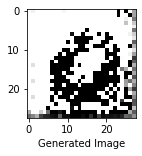

DicAcc: 1.0 ganLoss: 18.222259521484375 


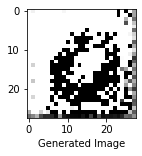

DicAcc: 1.0 ganLoss: 18.179988861083984 


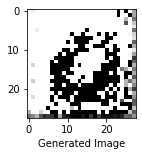

DicAcc: 1.0 ganLoss: 18.198970794677734 


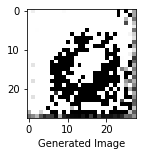

DicAcc: 1.0 ganLoss: 18.191007614135742 


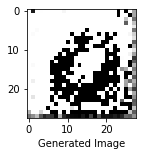

DicAcc: 1.0 ganLoss: 18.197023391723633 


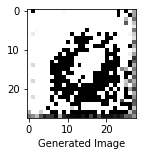

DicAcc: 1.0 ganLoss: 18.202747344970703 


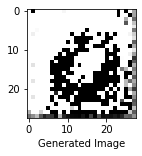

DicAcc: 1.0 ganLoss: 18.204811096191406 


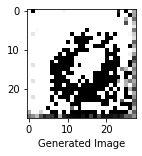

DicAcc: 1.0 ganLoss: 18.208881378173828 


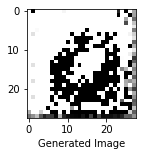

DicAcc: 1.0 ganLoss: 18.216148376464844 


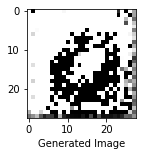

DicAcc: 1.0 ganLoss: 18.16537857055664 


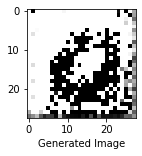

DicAcc: 1.0 ganLoss: 18.200420379638672 


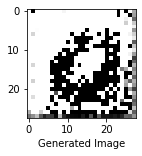

DicAcc: 1.0 ganLoss: 18.170812606811523 


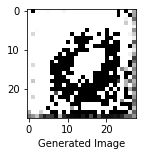

DicAcc: 1.0 ganLoss: 18.21326446533203 


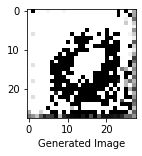

DicAcc: 1.0 ganLoss: 18.22622299194336 


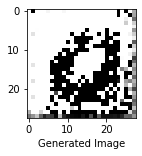

DicAcc: 1.0 ganLoss: 18.235218048095703 


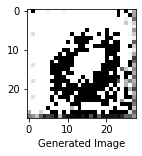

DicAcc: 1.0 ganLoss: 18.241125106811523 


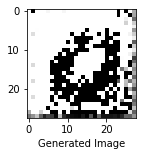

DicAcc: 1.0 ganLoss: 18.246910095214844 


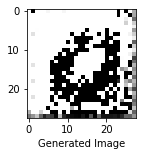

DicAcc: 1.0 ganLoss: 18.253433227539062 


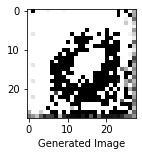

DicAcc: 1.0 ganLoss: 18.25486946105957 


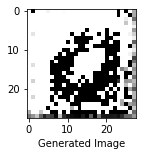

DicAcc: 1.0 ganLoss: 18.25798225402832 


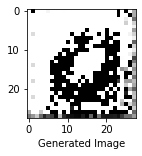

DicAcc: 1.0 ganLoss: 18.265911102294922 


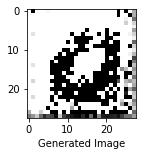

DicAcc: 1.0 ganLoss: 18.26058578491211 


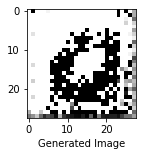

DicAcc: 1.0 ganLoss: 17.813926696777344 


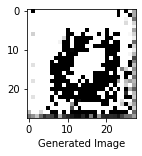

DicAcc: 1.0 ganLoss: 18.04632568359375 


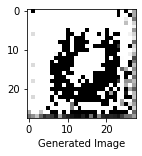

DicAcc: 1.0 ganLoss: 18.216955184936523 


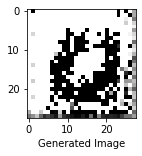

DicAcc: 1.0 ganLoss: 18.233409881591797 


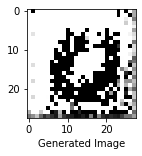

DicAcc: 1.0 ganLoss: 18.31301498413086 


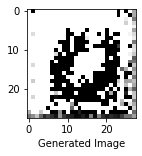

DicAcc: 1.0 ganLoss: 18.346277236938477 


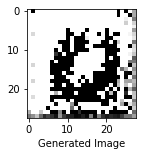

DicAcc: 1.0 ganLoss: 18.352489471435547 


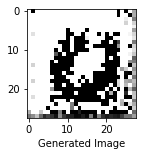

DicAcc: 1.0 ganLoss: 18.361858367919922 


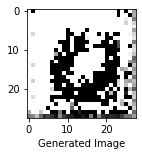

DicAcc: 1.0 ganLoss: 18.37172508239746 


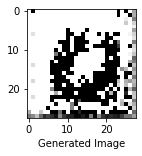

DicAcc: 1.0 ganLoss: 18.379119873046875 


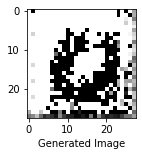

DicAcc: 1.0 ganLoss: 18.386016845703125 


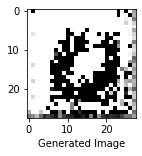

DicAcc: 1.0 ganLoss: 18.383684158325195 


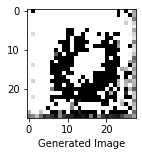

DicAcc: 1.0 ganLoss: 18.380273818969727 


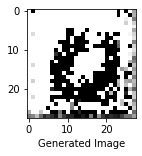

DicAcc: 1.0 ganLoss: 18.395370483398438 


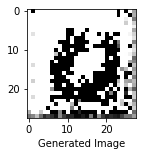

DicAcc: 1.0 ganLoss: 18.401721954345703 


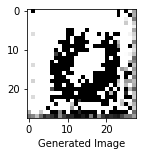

DicAcc: 1.0 ganLoss: 18.396217346191406 


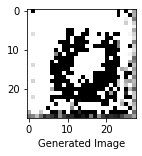

DicAcc: 1.0 ganLoss: 18.406755447387695 


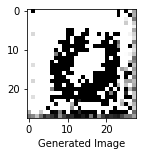

DicAcc: 1.0 ganLoss: 18.406370162963867 


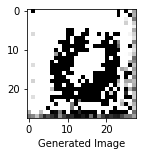

DicAcc: 1.0 ganLoss: 18.413372039794922 


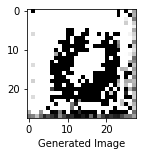

DicAcc: 1.0 ganLoss: 18.408353805541992 


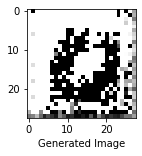

DicAcc: 1.0 ganLoss: 18.414581298828125 


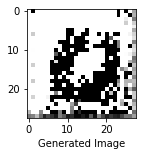

DicAcc: 1.0 ganLoss: 18.422964096069336 


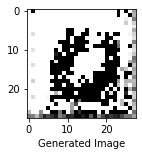

DicAcc: 1.0 ganLoss: 18.427227020263672 


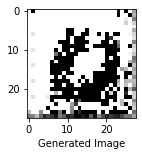

DicAcc: 1.0 ganLoss: 18.388671875 


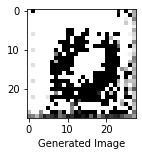

DicAcc: 1.0 ganLoss: 18.417739868164062 


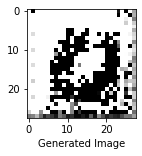

DicAcc: 1.0 ganLoss: 18.4277286529541 


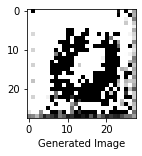

DicAcc: 1.0 ganLoss: 18.43520164489746 


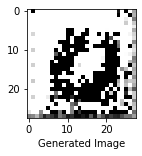

DicAcc: 1.0 ganLoss: 18.439682006835938 


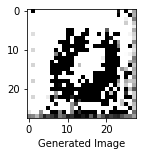

DicAcc: 1.0 ganLoss: 18.445842742919922 


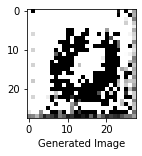

DicAcc: 1.0 ganLoss: 18.449935913085938 


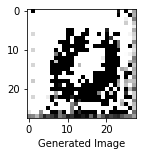

DicAcc: 1.0 ganLoss: 18.388710021972656 


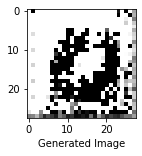

DicAcc: 1.0 ganLoss: 18.439682006835938 


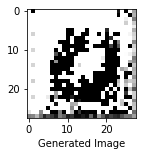

DicAcc: 1.0 ganLoss: 18.463825225830078 


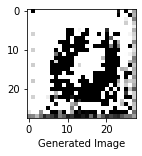

DicAcc: 1.0 ganLoss: 18.47598648071289 


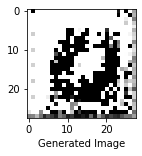

DicAcc: 1.0 ganLoss: 18.469295501708984 


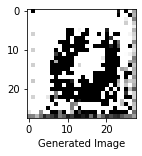

DicAcc: 1.0 ganLoss: 18.439617156982422 


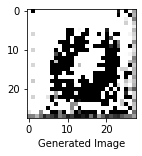

DicAcc: 1.0 ganLoss: 18.481056213378906 


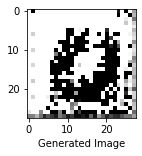

DicAcc: 1.0 ganLoss: 18.488018035888672 


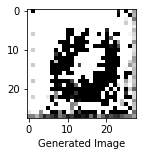

DicAcc: 1.0 ganLoss: 18.49408721923828 


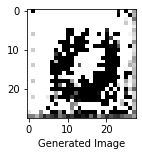

DicAcc: 1.0 ganLoss: 18.50705909729004 


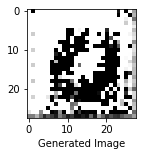

DicAcc: 1.0 ganLoss: 18.47934341430664 


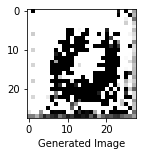

DicAcc: 1.0 ganLoss: 18.50895118713379 


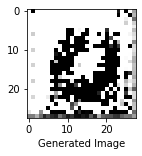

DicAcc: 1.0 ganLoss: 18.522403717041016 


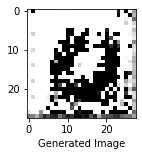

DicAcc: 1.0 ganLoss: 18.50971221923828 


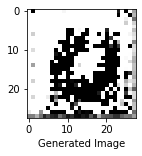

DicAcc: 1.0 ganLoss: 18.525785446166992 


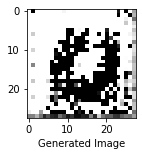

DicAcc: 1.0 ganLoss: 18.519731521606445 


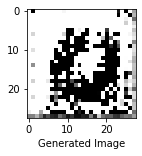

DicAcc: 1.0 ganLoss: 18.518478393554688 


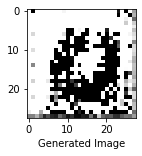

DicAcc: 1.0 ganLoss: 18.504940032958984 


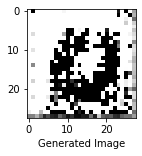

DicAcc: 1.0 ganLoss: 18.52138900756836 


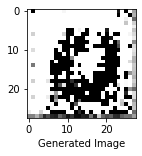

DicAcc: 1.0 ganLoss: 18.461872100830078 


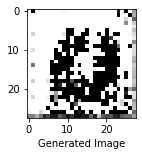

DicAcc: 1.0 ganLoss: 18.23172950744629 


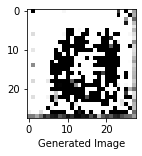

DicAcc: 1.0 ganLoss: 18.342201232910156 


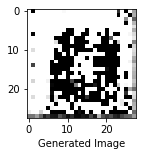

DicAcc: 1.0 ganLoss: 18.49791717529297 


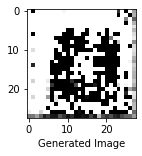

DicAcc: 1.0 ganLoss: 18.549861907958984 


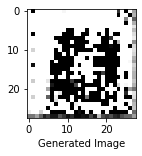

DicAcc: 1.0 ganLoss: 18.569820404052734 


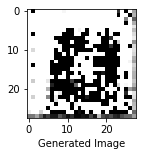

DicAcc: 1.0 ganLoss: 18.585693359375 


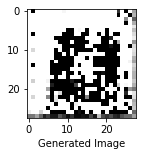

DicAcc: 1.0 ganLoss: 18.57542610168457 


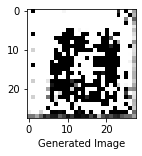

DicAcc: 1.0 ganLoss: 18.583026885986328 


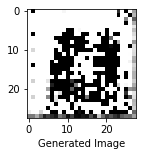

DicAcc: 1.0 ganLoss: 18.59375 


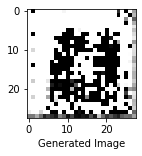

DicAcc: 1.0 ganLoss: 18.603240966796875 


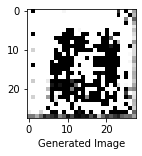

DicAcc: 1.0 ganLoss: 18.613731384277344 


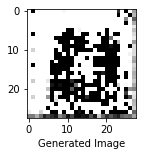

DicAcc: 1.0 ganLoss: 18.621843338012695 


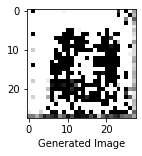

DicAcc: 1.0 ganLoss: 18.624942779541016 


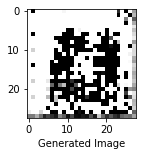

DicAcc: 1.0 ganLoss: 18.631805419921875 


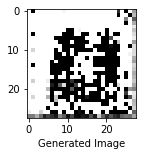

DicAcc: 1.0 ganLoss: 18.611404418945312 


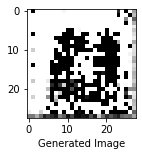

In [43]:

for e in range(0, epochs):

  for step in range(0, step_per_epoch):

    true_example = x[int(batch_size/2)*step : int(batch_size/2)*(step+1)]
    true_example = np.reshape(true_example, (true_example.shape[0], 28, 28, 1))

    noise = np.random.randn(int(batch_size/2), 1)
    gen_example = generator.predict(noise)

    x_batch = np.concatenate([gen_example, true_example], axis = 0)
    y_batch = np.array([0]*int(batch_size/2) + [1]*int(batch_size/2))

    indices = np.random.choice(range(batch_size), batch_size, replace=False)

    x_batch = x_batch[indices]
    y_batch = y_batch[indices]

    discriminator.trainable = True
    discriminator.train_on_batch(x_batch, y_batch)
    discriminator.trainable = False

    loss, _ = GAN.train_on_batch(noise, np.ones((int(batch_size/2), 1)))
    _, acc = discriminator.evaluate(x_batch, y_batch, verbose=0)

  noise = np.random.randn(1, 1)
  gen_img = generator.predict(noise)[0]
  gen_img = np.reshape(gen_img, (28,28))
  print(f'DicAcc: {acc} ganLoss: {loss} ')
  plt.figure(figsize=(50,2))
  plt.imshow(gen_img, cmap='binary')
  plt.xlabel('Generated Image')
  plt.show()

